In [1]:
#this notebook takes an images and gives back the vgg16 fc1 layer, without performing relu!

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py
from scipy import misc
import os
import random

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"# use cpu

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

[u'/cpu:0']

In [5]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [6]:
#loading the vgg16 net with all the weights
model = VGG16(weights='imagenet', include_top=True,input_shape=(224,224,3))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
#get the weights of the fc1 layer
fc1=model.get_layer("fc1")

In [9]:
fc1_weights=fc1.get_weights()

In [10]:
#define a "new model" taht only goes until the flatten layer
from keras.models import Model
model_flaten_layer = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

In [11]:
h5f_X = h5py.File('/home/murl/CAS_DL_test/Data_8_faces_no_cut_bigger.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']

X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']


X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']


[u'X_test_8_faces', u'X_train_8_faces', u'X_valid_8_faces', u'Y_test_8_faces', u'Y_train_8_faces', u'Y_valid_8_faces']
(2000, 100, 100, 3)
(400, 100, 100, 3)
(400, 100, 100, 3)


In [12]:
img=X_train[0]

In [13]:
img.shape

(100, 100, 3)

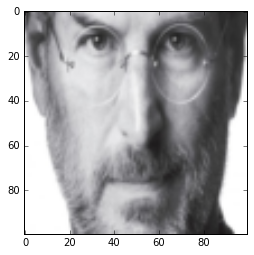

In [14]:
plt.imshow(np.asarray(img,dtype="uint8"))

In [15]:
from scipy import misc
img_resized=misc.imresize(img,[224,224])

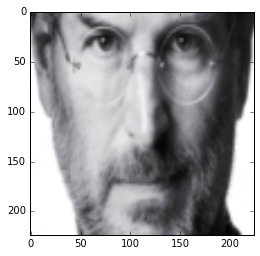

In [16]:
plt.imshow(np.asarray(img_resized,dtype="uint8"))

In [17]:
img_resized=np.asarray(img_resized,dtype="float64")

In [18]:
img_resized = np.expand_dims(img_resized, axis=0)
img_resized = preprocess_input(img_resized)

In [19]:
#get the "features" or predict until the flatten layer
features=model_flaten_layer.predict(img_resized)
#features=model.predict(x)

In [20]:
features.shape

(1, 25088)

In [21]:
#get weights and bias of the fc1 weight list
W=(fc1_weights[0])
b=(fc1_weights[1])
print(W.shape)
print(b.shape)

(25088, 4096)
(4096,)


In [22]:
Data=[W,b]

In [24]:
EMB_train=np.zeros((len(X_train),4096))
for i in range(0,len(X_train)):
    img=X_train[i]
    img_resized=misc.imresize(img,[224,224])
    img_resized=np.asarray(img_resized,dtype="float64")
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = preprocess_input(img_resized)
    features=model_flaten_layer.predict(img_resized)
    EMB_train[i]=np.matmul(features,W)+b
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [25]:
EMB_valid=np.zeros((len(X_valid),4096))
for i in range(0,len(X_valid)):
    img=X_valid[i]
    img_resized=misc.imresize(img,[224,224])
    img_resized=np.asarray(img_resized,dtype="float64")
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = preprocess_input(img_resized)
    features=model_flaten_layer.predict(img_resized)
    EMB_valid[i]=np.matmul(features,W)+b
    if i % 100 == 0:
        print(i)

0
100
200
300


In [26]:
EMB_test=np.zeros((len(X_test),4096))
for i in range(0,len(X_test)):
    img=X_test[i]
    img_resized=misc.imresize(img,[224,224])
    img_resized=np.asarray(img_resized,dtype="float64")
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = preprocess_input(img_resized)
    features=model_flaten_layer.predict(img_resized)
    EMB_test[i]=np.matmul(features,W)+b
    if i % 100 == 0:
        print(i)

0
100
200
300


In [27]:
np.savez_compressed("/home/murl/CAS_DL_test/8_faces_EMB",EMB_train,EMB_valid,EMB_test,Y_train,Y_valid,Y_test)